# Hierarchical Equal Risk Contribution with MlFinLab

## Abstract
The following notebook will explore MlFinLab's implementation of Thomas Raffinot's Hierarchical Equal Risk Contribution portfolio optimization technique. Users will be taken through how they can construct an optimal portfolio and the different risk metrics and linkage algorithms supported. Additionally, users will be able to see how they can create custom use cases with this library.

## Introduction
This tutorial will show users how to optimize a portfolio using the __[Hierarchical Equal Risk Contribution](https://ssrn.com/abstract=3237540)__ (HERC) optimization technique provided through the MlFinLab library. The HERC technique was developed by Thomas Raffinot in 2018, which built off his original __[Hierarchical Clustering Asset Allocation](https://ssrn.com/abstract=2840729)__ (HCAA) technique from 2017. The official documentation for this tutorial can be found __[here](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_equal_risk_contribution.html)__. 


From Raffinot's 2018 paper on the HERC optimization technique, the following steps for implementation of the HCAA and HERC techniques were shown. 

Raffinot described the HCAA implementation in four steps:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Capital is allocated across clusters
4. Capital is allocated within clusters

HERC is built off this original implementation, combining the machine learning approach of the HCAA technique with the Top-Down recursive bisection approach from the __[Hierarchical Risk Parity](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__ algorithm. The HERC algorithm aims to diversify capital and risk allocations throughout the portfolio.

The steps for the HERC implementation are computed as:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Top-Down recursive bisection
4. Implement Naive Risk Parity within clusters to allocate weights to each asset

### Supported Risk Measures

The HERC implementation provided through MlFinLab currently supports the following metrics for calculating weight allocations:
1. 'variance': The variance of the clusters is used as a risk metric
2. 'standard_deviation': The standard deviation of the clusters is used as a risk metric
3. 'equal_weighting': All clusters are weighted equally with respect to the risk
4. 'expected_shortfall': The expected shortfall of the clusters is used as a risk metric
5. 'conditional_drawdown_risk': The conditional drawdown at risk of the clusters is used as a risk metric

### Supported Linkage Methods

Additionally, MlFinLab allows users to customize the type of linkage algorithm for the use of clustering. The current supported linkage methods are:
1. Single Linkage - the distance between two clusters is the minimum distance between any two points in the clusters
2. Complete Linkage - the distance between two clusters is the maximum of the distance between any two points in the clusters
3. Average Linkage - the distance between two clusters is the average of the distance between any two points in the clusters
4. Ward Linkage - the distance between two clusters is the increase of the squared error from when two clusters are merged

**The default linkage method in MlFinLab is set as the Ward Linkage method.** To learn more about the different types of linkage methods, please refer to Raffinot's paper on the __[HCAA method](https://ssrn.com/abstract=2840729)__ or to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_equal_risk_contribution.html)__. 

In [16]:
# importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.portfolio_optimization.herc import HierarchicalEqualRiskContribution

## The Data

In this tutorial, we will be working with the historical closing prices for 17 assets from 2010-2018. The data we are working with was chosen because the clustering structure is clearly visible so it as a very good dataset for working with and visualizing various clustering techniques.

In [17]:
# preparing our data
raw_prices = pd.read_csv("../../Sample-Data/assetalloc.csv", sep=';', parse_dates=True, index_col='Dates', dayfirst=True)
stock_prices = raw_prices.sort_values(by='Dates')
stock_prices.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-02-01,2039.7,875.47,297.09,392.50,99.081,99.039,99.572,100.000,100.031,100.345,101.080,101.936,154.38,117.50,1636.57,133.584,286.67
1989-02-02,2043.4,878.08,296.84,392.00,98.898,99.117,99.278,99.692,100.000,100.314,101.017,101.905,154.94,117.69,1642.94,135.052,287.03
1989-02-03,2069.9,884.09,296.97,388.75,98.907,99.002,99.145,99.178,99.812,100.062,100.921,101.718,155.69,118.62,1659.11,137.134,285.63
1989-02-06,2044.3,885.49,296.04,388.00,98.484,98.502,98.510,97.739,99.812,100.062,100.794,101.468,155.58,118.89,1656.86,137.037,284.69
1989-02-07,2072.8,883.82,299.63,392.75,98.438,98.312,98.292,97.688,99.906,100.251,101.144,102.092,156.84,118.28,1662.76,136.914,284.21


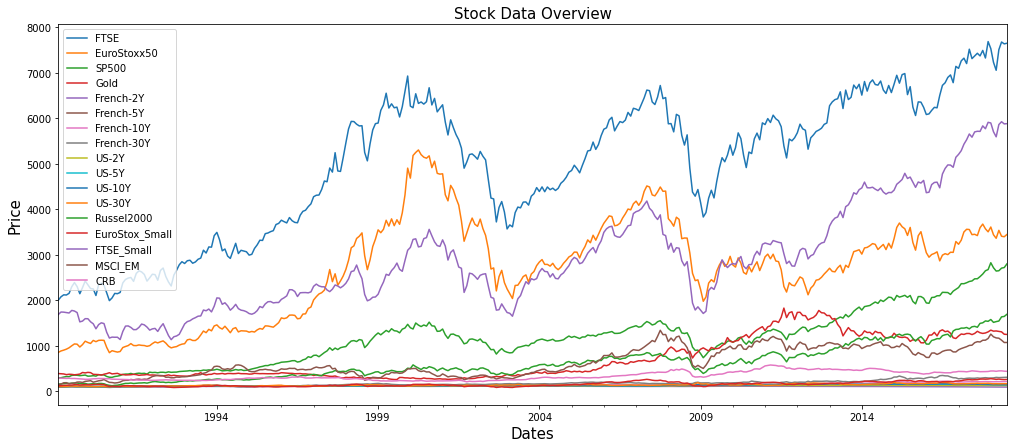

In [18]:
# taking a quick look at our most recent 5000 data points
stock_prices.resample('M').last().plot(figsize=(17,7))
plt.ylabel('Price', size=15)
plt.xlabel('Dates', size=15)
plt.title('Stock Data Overview', size=15)
plt.show()

We can also plot the volatility of our stocks as well for further inspection.

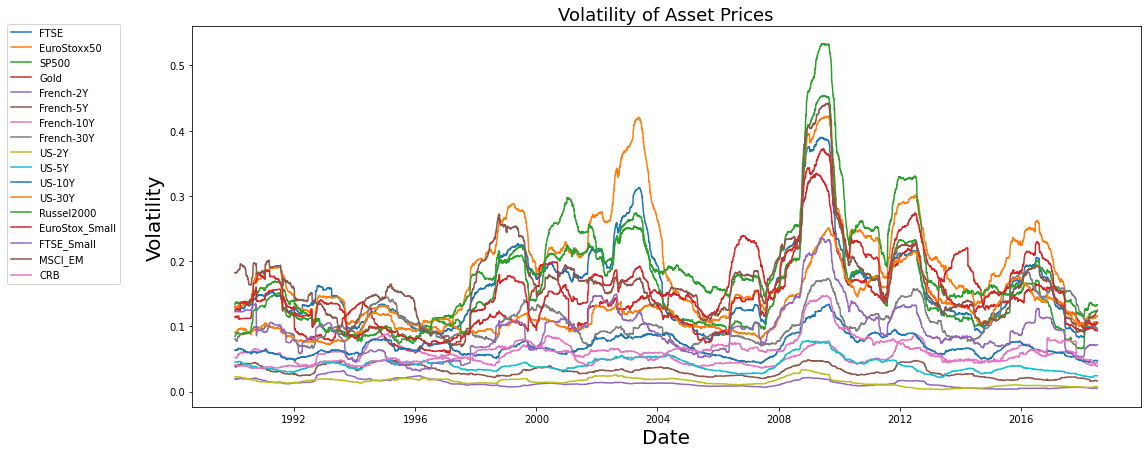

In [19]:
# plotting the volatility of our stocks
volatility = stock_prices.pct_change().rolling(window=252).std()*(252**0.5)

plt.figure(figsize=(17,7))
plt.plot(volatility)
plt.ylabel('Volatility', size=20)
plt.xlabel('Date', size=20)
plt.title('Volatility of Asset Prices', size=18)
plt.legend(stock_prices.columns, loc='upper left', bbox_to_anchor=(-0.2, 1.02))
plt.show()

## Equal Weighting Portfolio
In the Equal Weighting portfolio, all the clusters are weighted equally in terms of risk to construct our optimal portfolio. The following image shows how asset allocation works with a small example, and highlights how important choosing the optimal number of clusters is in our algorithm.

<img src='ex_dendo2.jpg' style="width:400px;height:400px"/>



In this example, we will also be showing the different effects of using the four different linkage algorithms. We will first be using the Single Linkage method, then the Complete Linkage method, followed by the Average Linkage method, and finally the Ward Linkage method. Keep in mind that the default linkage algorithm is set to the Ward Linkage algorithm.

Note that the allocate method for the HierarchicalEqualRiskContribution() object requires three parameters to run: 
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)
3. risk_measure (the type of solution/algorithm to use to calculate the weights)

Users can also specify: 
1. The type of linkage algorithm (shown below) 
2. The confidence level used for calculating expected shortfall and conditional drawdown at risk 
3. The optimal number of clusters for clustering
4. How to resample the prices

For simplicity, we will only be working with the three required parameters and also specifying our linkage algorithm of choice. For more detailed notes on this implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_equal_risk_contribution.html)__. 

In [5]:
# HERC implementation with equal_weighting solution - Single Linkage
hercEW_single = HierarchicalEqualRiskContribution()
hercEW_single.allocate(asset_names=stock_prices.columns,
                       asset_prices=stock_prices,
                       risk_measure='equal_weighting',
                       linkage='single')

print("Equal Weighting Portfolio Weights - Single Linkage \n", hercEW_single.weights)

Equal Weighting Portfolio Weights - Single Linkage 
     US-2Y  US-30Y   US-5Y  US-10Y  French-30Y  French-10Y  French-2Y  \
0  0.0625  0.0625  0.0625  0.0625      0.0625      0.0625     0.0625   

   French-5Y  Gold    CRB    SP500  Russel2000  MSCI_EM  FTSE_Small    FTSE  \
0     0.0625  0.25  0.125  0.03125     0.03125   0.0125      0.0125  0.0125   

   EuroStoxx50  EuroStox_Small  
0       0.0125          0.0125  


To save on computation time, we can print out the optimal number of clusters computed from our first optimized portfolio and pass it in as a parameter to our other portfolios.

In [6]:
print(hercEW_single.optimal_num_clusters)

6


In [20]:
# HERC implementation with equal_weighting solution - Complete Linkage
hercEW_complete = HierarchicalEqualRiskContribution()
hercEW_complete.allocate(asset_names=stock_prices.columns,
                         asset_prices=stock_prices,
                         risk_measure='equal_weighting',
                         optimal_num_clusters=6,
                         linkage='complete')

print("Equal Weighting Portfolio Weights - Complete Linkage \n", hercEW_complete.weights)

Equal Weighting Portfolio Weights - Complete Linkage 
     US-2Y  US-30Y   US-5Y  US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.0625  0.0625  0.0625  0.0625     0.0625     0.0625      0.0625   

   French-30Y   SP500  Russel2000  MSCI_EM  FTSE_Small   FTSE  EuroStoxx50  \
0      0.0625  0.0625      0.0625    0.025       0.025  0.025        0.025   

   EuroStox_Small   Gold    CRB  
0           0.025  0.125  0.125  


In [21]:
# HERC implementation with equal_weighting solution - Average Linkage
hercEW_average = HierarchicalEqualRiskContribution()
hercEW_average.allocate(asset_names=stock_prices.columns,
                        asset_prices=stock_prices,
                        risk_measure='equal_weighting',
                        optimal_num_clusters=6,
                        linkage='average')

print("Equal Weighting Portfolio Weights - Average Linkage \n", hercEW_average.weights)

Equal Weighting Portfolio Weights - Average Linkage 
     CRB   SP500  Russel2000  MSCI_EM  FTSE_Small   FTSE  EuroStoxx50  \
0  0.25  0.0625      0.0625    0.025       0.025  0.025        0.025   

   EuroStox_Small  Gold    US-2Y   US-30Y    US-5Y   US-10Y  French-2Y  \
0           0.025  0.25  0.03125  0.03125  0.03125  0.03125    0.03125   

   French-5Y  French-10Y  French-30Y  
0    0.03125     0.03125     0.03125  


In [22]:
# HERC implementation with equal_weighting solution - Ward Linkage
hercEW_ward = HierarchicalEqualRiskContribution()
hercEW_ward.allocate(asset_names=stock_prices.columns,
                     asset_prices=stock_prices,
                     risk_measure='equal_weighting',
                     optimal_num_clusters=6,
                     linkage='ward')

print("Equal Weighting Portfolio Weights - Ward Linkage \n", hercEW_ward.weights)

Equal Weighting Portfolio Weights - Ward Linkage 
     Gold    CRB   SP500  Russel2000   FTSE  EuroStoxx50  EuroStox_Small  \
0  0.125  0.125  0.0625      0.0625  0.025        0.025           0.025   

   FTSE_Small  MSCI_EM   US-2Y  US-30Y   US-5Y  US-10Y  French-2Y  French-5Y  \
0       0.025    0.025  0.0625  0.0625  0.0625  0.0625     0.0625     0.0625   

   French-10Y  French-30Y  
0      0.0625      0.0625  


MlFinLab also allows us to plot the produced dendrogram from our optimal portfolios. This method can be accessed through the method name 'plot_clusters()'. The different colours in the x-labels of our produced dendrogram represent each cluster in our algorithm.

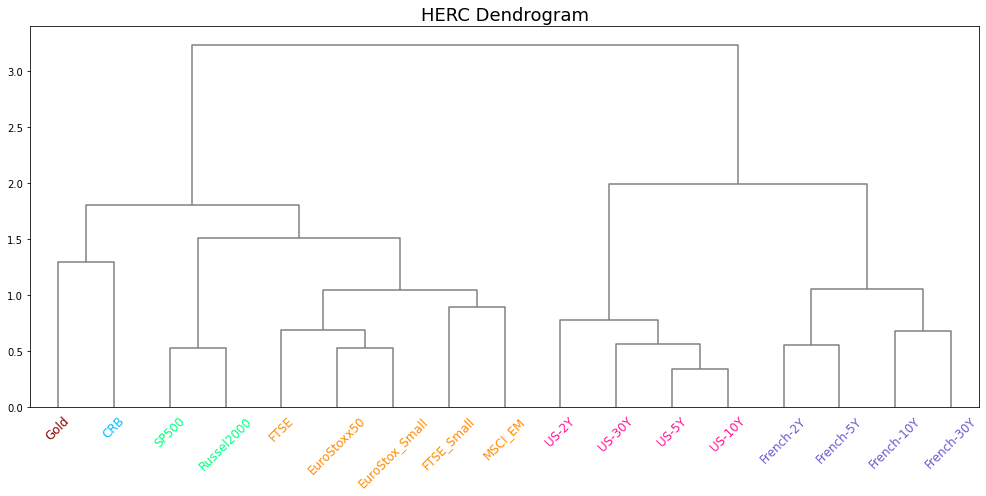

In [23]:
plt.figure(figsize=(17,7))
hercEW_ward.plot_clusters(assets=stock_prices.columns)
plt.title('HERC Dendrogram', size=18)
plt.xticks(rotation=45)
plt.show()

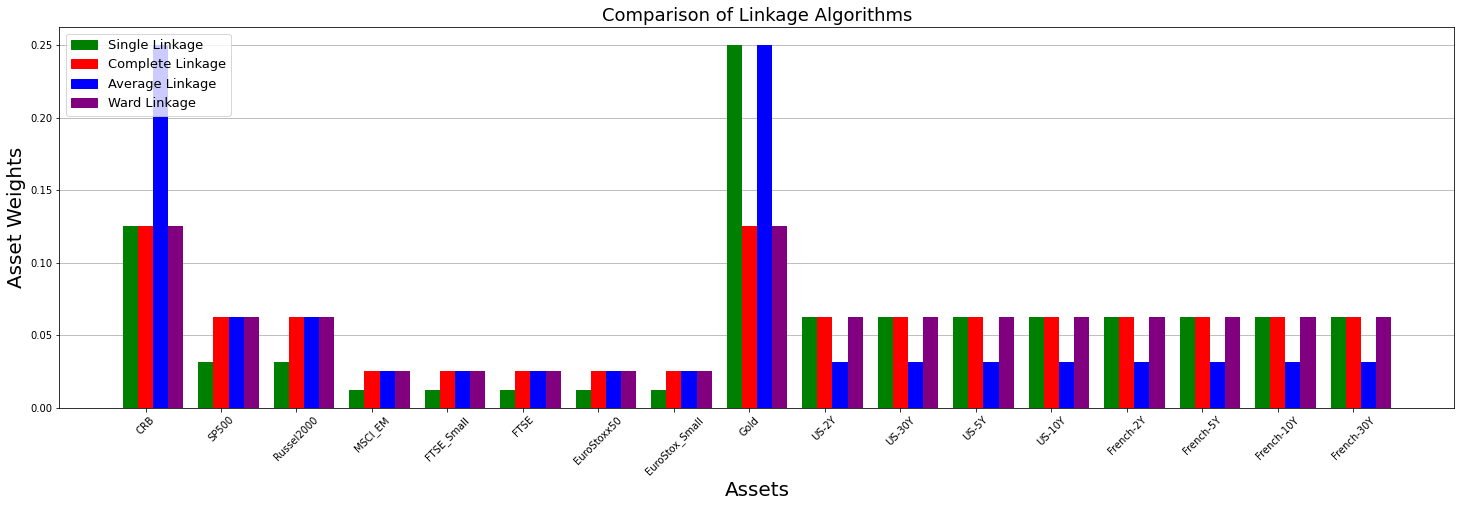

In [26]:
# comparing our four Linkage algorithms
average_linkage = hercEW_average.weights
complete_linkage = hercEW_complete.weights[average_linkage.columns]
single_linkage = hercEW_single.weights[average_linkage.columns]
ward_linkage = hercEW_ward.weights[average_linkage.columns]

x = np.arange(len(average_linkage.columns))
bar_width = 0.2

plt.figure(figsize=(25,7))
plt.bar(x, single_linkage.values[0], color='green', width=bar_width, zorder=2)
plt.bar(x + bar_width, complete_linkage.values[0], color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, average_linkage.values[0], color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, ward_linkage.values[0], color='purple', width=bar_width, zorder=2)

plt.xticks(x + bar_width, average_linkage, rotation=45, size=10)
plt.title('Comparison of Linkage Algorithms', size=18)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)

green_patch = mpatches.Patch(color='green', label='Single Linkage')
red_patch = mpatches.Patch(color='red', label='Complete Linkage')
blue_patch = mpatches.Patch(color='blue', label='Average Linkage')
purple_patch=mpatches.Patch(color='purple', label='Ward Linkage')
plt.legend(handles=[green_patch, red_patch, blue_patch, purple_patch], loc='upper left', prop={'size': 13})

plt.grid(axis='y')

plt.show()

Through this implementation, we can see how the four different linkage algorithms affect our optimal portfolio creation.

## Standard Deviation Portfolio
The Standard Deviation portfolio uses the standard deviation of the clusters as a risk metric to solve for the optimal portfolio. 

In [27]:
# HERC implementation with standard_deviation solution
hercMSD = HierarchicalEqualRiskContribution()
hercMSD.allocate(asset_names=stock_prices.columns,
                 asset_prices=stock_prices,
                 optimal_num_clusters=6,
                 risk_measure='standard_deviation')

print("Standard Deviation Portfolio Weights \n", hercMSD.weights)

Standard Deviation Portfolio Weights 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.012148  0.028957  0.007072    0.005204  0.002705     0.001818   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0        0.002973    0.007654  0.002457  0.347802  0.005555  0.050624   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.017721   0.402035   0.074922     0.02392    0.006433  


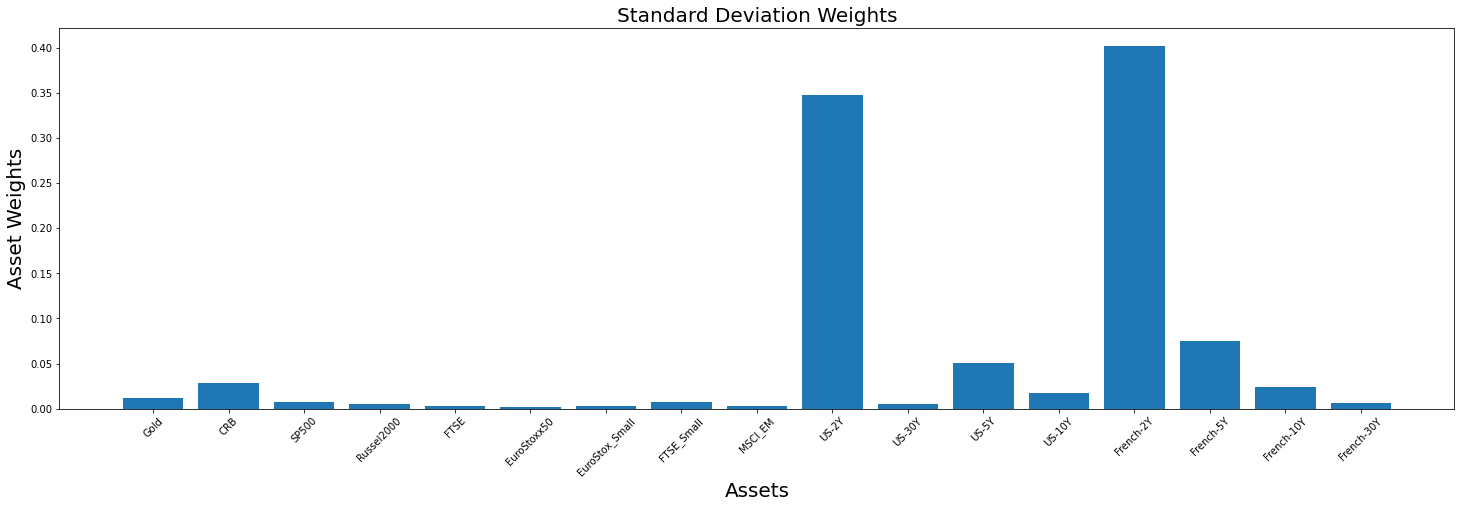

In [28]:
# plotting our optimal portfolio
hercMSD_weights = hercMSD.weights
y_pos = np.arange(len(hercMSD_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hercMSD_weights.columns), hercMSD_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Standard Deviation Weights', size=20)
plt.show()

## Variance Portfolio
The Variance portfolio uses the variance of the clusters as a risk metric to calculate asset weights. 

In [29]:
# HERC implementation with variance solution
hercMV = HierarchicalEqualRiskContribution()
hercMV.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                optimal_num_clusters=6,
                risk_measure='variance')

print("Variance Portfolio Weights \n", hercMV.weights)

Variance Portfolio Weights 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.000987  0.005609  0.000743    0.000547  0.000408     0.000274   

   EuroStox_Small  FTSE_Small  MSCI_EM     US-2Y    US-30Y     US-5Y  \
0        0.000448    0.001154  0.00037  0.333466  0.005326  0.048537   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.016991   0.463714   0.086416     0.02759     0.00742  


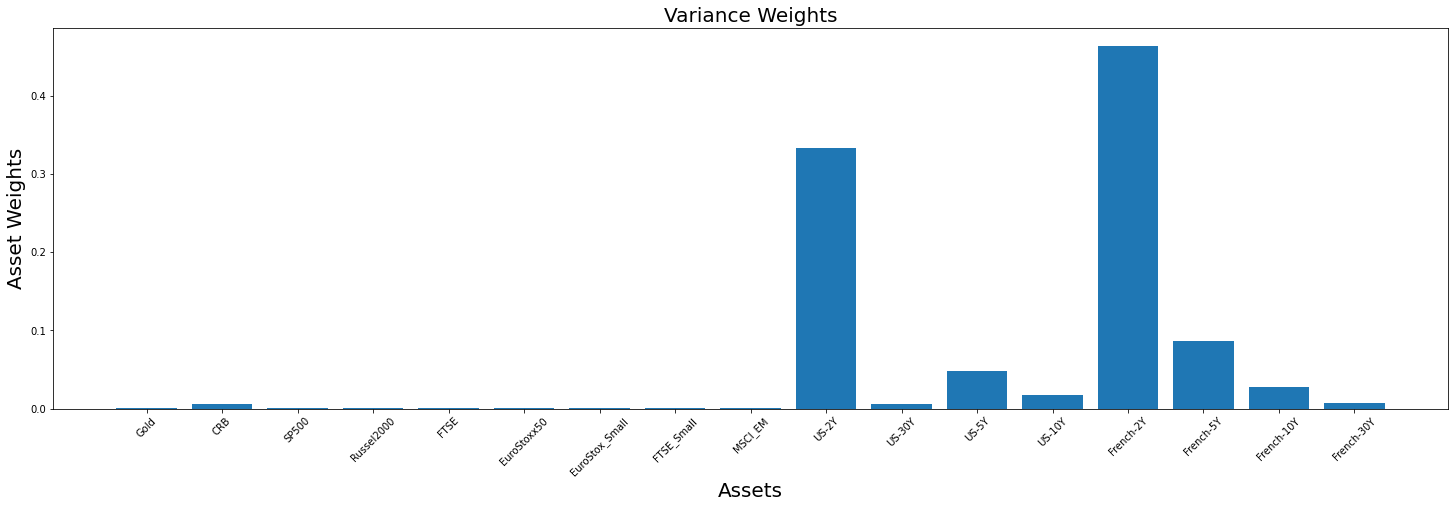

In [30]:
# plotting our optimal portfolio
hercMV_weights = hercMV.weights
y_pos = np.arange(len(hercMV_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hercMV_weights.columns), hercMV_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Variance Weights', size=20)
plt.show()

## Expected Shortfall Portfolio
The Expected Shortfall (CVaR) of the clusters is now being used as a risk metric to contruct our optimal portfolio.

In [31]:
# HERC implementation with expected_shortfall solution
hercES = HierarchicalEqualRiskContribution()
hercES.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                optimal_num_clusters=6,
                risk_measure='expected_shortfall')

print("Expected Shortfall Portfolio Weights \n", hercES.weights)

Expected Shortfall Portfolio Weights 
       Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.01697  0.041323  0.009512    0.008156  0.004275     0.003428   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0        0.004147    0.006424  0.003942  0.229564  0.028883  0.088471   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.052172   0.276809   0.121856    0.068915    0.035151  


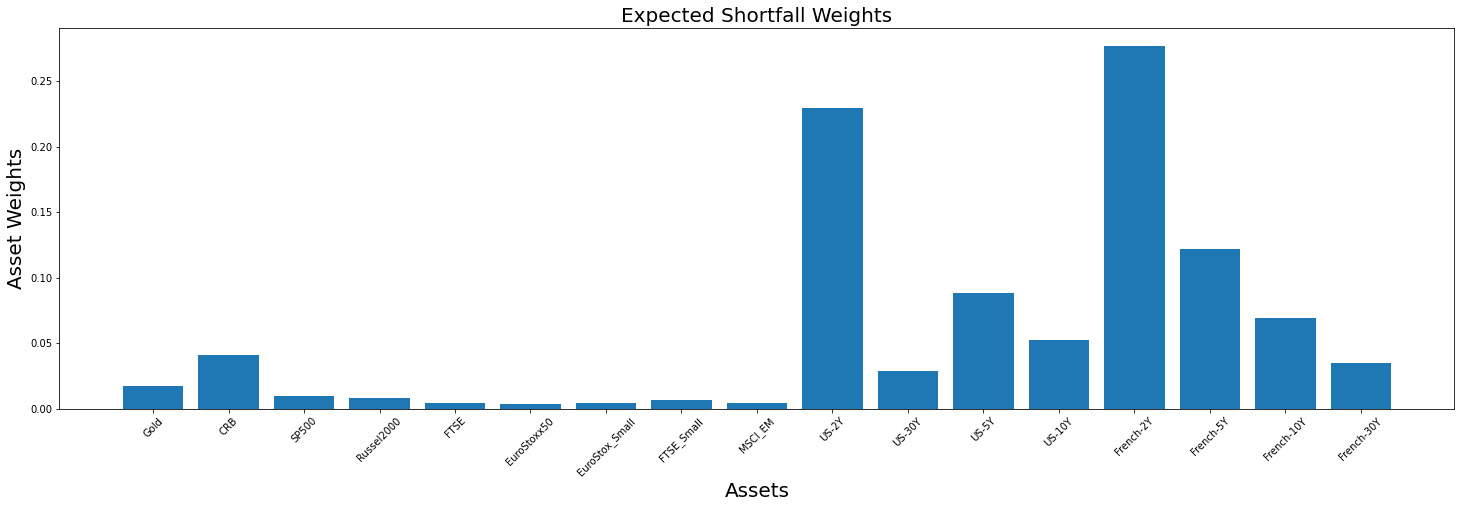

In [32]:
# plotting our optimal portfolio
hercES_weights = hercES.weights
y_pos = np.arange(len(hercES_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hercES_weights.columns), hercES_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Expected Shortfall Weights', size=20)
plt.show()

## Conditional Drawdown at Risk Portfolio
The Conditional Drawdown at Risk (CDaR) of the clusters is used as a risk metric.

In [33]:
# HERC implementation with conditional_drawdown_at_risk solution
hercCDR = HierarchicalEqualRiskContribution()
hercCDR.allocate(asset_names=stock_prices.columns,
                 asset_prices=stock_prices,
                 optimal_num_clusters=6,
                 risk_measure='conditional_drawdown_risk')

print("Conditional Drawdown at Risk Portfolio Weights \n", hercCDR.weights)

Conditional Drawdown at Risk Portfolio Weights 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.015934  0.034344  0.007467     0.00729  0.003866     0.003485   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0        0.004421    0.006497  0.003483  0.188334  0.036314  0.094146   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.059675    0.22293   0.165948    0.098491    0.047376  


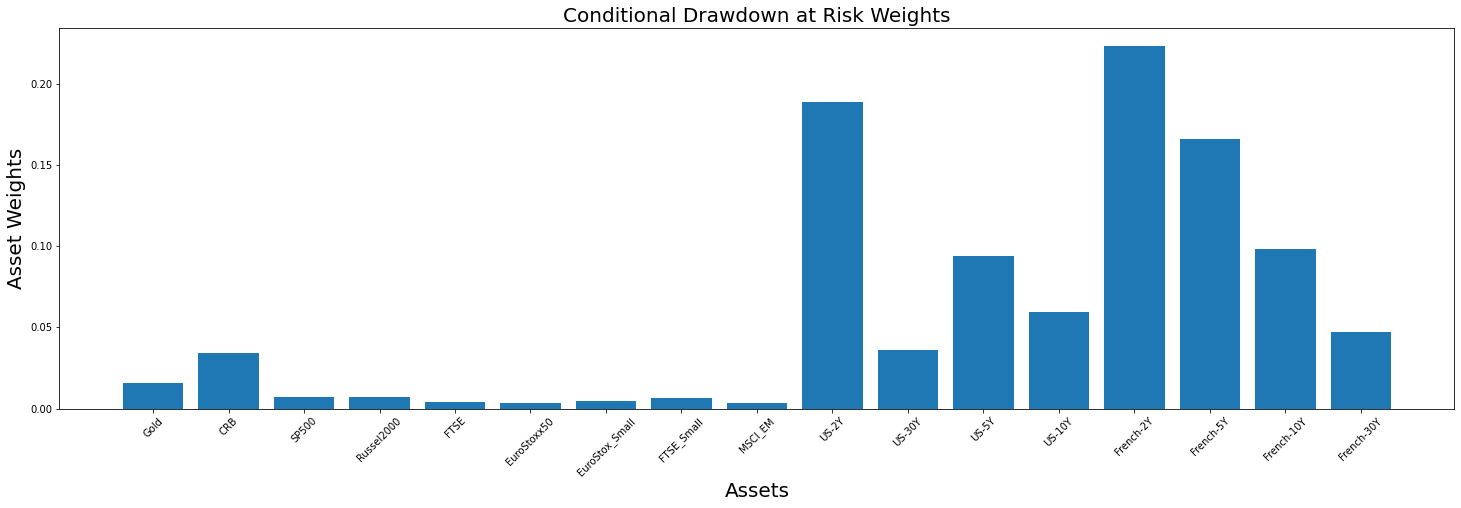

In [34]:
# plotting our optimal portfolio
hercCDR_weights = hercCDR.weights
y_pos = np.arange(len(hercCDR_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(hercCDR_weights.columns), hercCDR_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Conditional Drawdown at Risk Weights', size=20)
plt.show()

## Comparison of Risk Measures
In the following graph, we can see how the portfolio weightings differ for each solution.

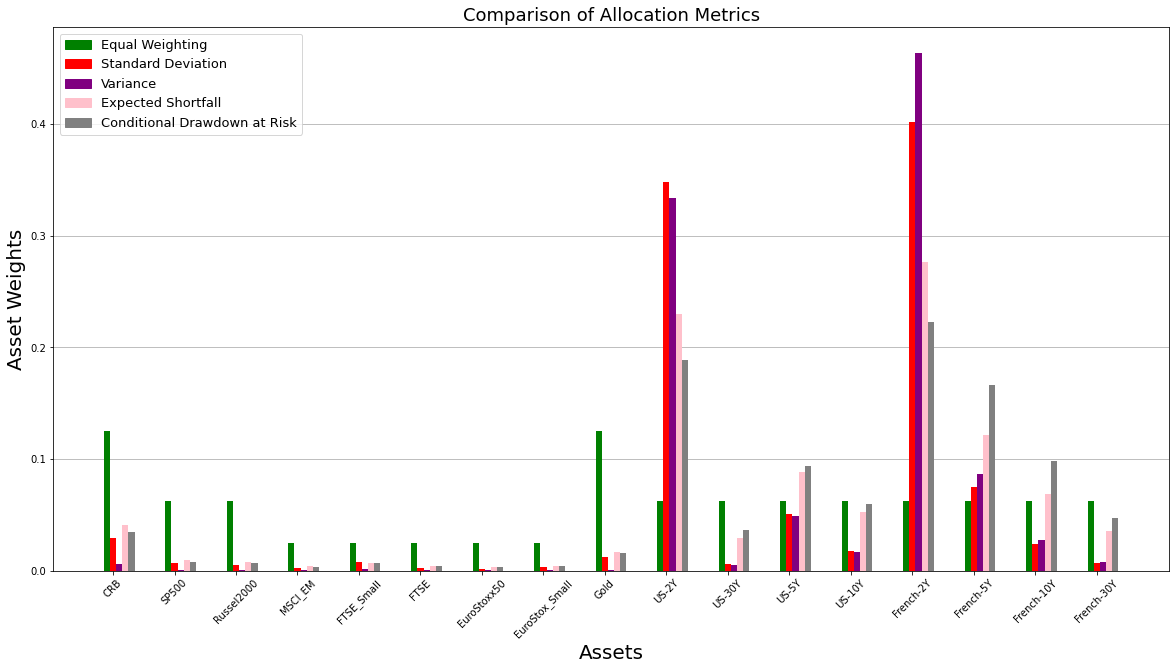

In [37]:
MSD_weights = hercMSD_weights[ward_linkage.columns]
MV_weights = hercMV_weights[ward_linkage.columns]
ES_weights = hercES_weights[ward_linkage.columns]
CDR_weights = hercCDR_weights[ward_linkage.columns]

x = np.arange(len(ward_linkage.columns))
bar_width = 0.1

plt.figure(figsize=(20,10))
plt.bar(x, ward_linkage.values[0], color='green', width=bar_width, zorder=2)
plt.bar(x + bar_width, MSD_weights.values[0], color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, MV_weights.values[0], color='purple', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, ES_weights.values[0], color='pink', width=bar_width, zorder=2)
plt.bar(x + bar_width*4, CDR_weights.values[0], color='grey', width=bar_width, zorder=2)

plt.xticks(x + bar_width, ward_linkage, rotation=45, size=10)
plt.title('Comparison of Allocation Metrics', size=18)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)

green_patch = mpatches.Patch(color='green', label='Equal Weighting')
red_patch = mpatches.Patch(color='red', label='Standard Deviation')
purple_patch=mpatches.Patch(color='purple', label='Variance')
pink_patch = mpatches.Patch(color='pink', label='Expected Shortfall')
grey_patch=mpatches.Patch(color='grey', label='Conditional Drawdown at Risk')
plt.legend(handles=[green_patch, red_patch, purple_patch, pink_patch, grey_patch], loc='upper left', prop={'size': 13})

plt.grid(axis='y')

plt.show()

## Custom Input from Users
MlFinLab also provides users with a lot of customizability when it comes to creating their optimal portfolios. Instead of providing the raw historical closing prices for the assets, users can input the asset returns and a covariance matrix of asset returns. If you would like to learn more about the customizbility within MlFinLab's HERC implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_equal_risk_contribution.html)__.

The following parameters in the allocate() method are utilized in order to construct a custom use case:
1. 'asset_returns': (pd.DataFrame/NumPy matrix) A matrix of asset returns
2. 'covariance_matrix': (pd.DataFrame/NumPy matrix) A covariance matrix of asset returns

In this example of using custom input, we will be constructing an optimal portfolio under the Conditional Drawdown at Risk solution.

To make some of the necessary calculations, we will make use of the ReturnsEstimators class provided by MlFinLab.

In [38]:
# importing ReturnsEstimation class from MlFinLab
from mlfinlab.portfolio_optimization.returns_estimators import ReturnsEstimators

In [39]:
# calculating our asset returns
returns = ReturnsEstimators.calculate_returns(stock_prices)
returns.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
1989-02-02,0.001814,0.002981,-0.000841,-0.001274,-0.001847,0.000788,-0.002953,-0.003080,-0.000310,-0.000309,-0.000623,-0.000304,0.003627,0.001617,0.003892,0.010989,0.001256
1989-02-03,0.012969,0.006844,0.000438,-0.008291,0.000091,-0.001160,-0.001340,-0.005156,-0.001880,-0.002512,-0.000950,-0.001835,0.004841,0.007902,0.009842,0.015416,-0.004878
1989-02-06,-0.012368,0.001584,-0.003132,-0.001929,-0.004277,-0.005050,-0.006405,-0.014509,0.000000,0.000000,-0.001258,-0.002458,-0.000707,0.002276,-0.001356,-0.000707,-0.003291
1989-02-07,0.013941,-0.001886,0.012127,0.012242,-0.000467,-0.001929,-0.002213,-0.000522,0.000942,0.001889,0.003472,0.006150,0.008099,-0.005131,0.003561,-0.000898,-0.001686
1989-02-08,0.011289,0.009040,-0.003271,-0.005729,0.001219,0.003519,0.004721,0.002099,-0.000941,-0.000948,-0.001266,-0.004280,0.001020,0.003805,0.011481,0.000825,0.000598


In [40]:
# calculating our covariance matrix
cov = returns.cov()
cov

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
FTSE,1.146945e-04,0.000116,5.643606e-05,-3.081248e-06,-8.832561e-07,-2.423788e-06,-3.877263e-06,-0.000007,-1.684947e-06,-5.204467e-06,-0.000009,-0.000017,6.135381e-05,8.225258e-05,4.439900e-05,6.415264e-05,7.666681e-06
EuroStoxx50,1.156055e-04,0.000171,7.300403e-05,-8.984117e-06,-1.007815e-06,-3.028229e-06,-4.756979e-06,-0.000009,-2.485549e-06,-7.711391e-06,-0.000013,-0.000025,8.212584e-05,1.151939e-04,5.028051e-05,7.834393e-05,8.579117e-06
SP500,5.643606e-05,0.000073,1.166470e-04,-5.160036e-06,-7.911315e-07,-2.029786e-06,-3.471091e-06,-0.000006,-1.831687e-06,-5.366541e-06,-0.000009,-0.000017,1.169106e-04,5.176979e-05,2.052664e-05,4.920214e-05,5.734262e-06
Gold,-3.081248e-06,-0.000009,-5.160036e-06,9.391228e-05,5.410605e-07,1.476888e-06,2.321374e-06,0.000003,4.275486e-07,1.104387e-06,0.000001,0.000002,-3.318860e-06,-2.983680e-06,5.254349e-07,1.190630e-05,6.521527e-06
French-2Y,-8.832561e-07,-0.000001,-7.911315e-07,5.410605e-07,7.601231e-07,1.489883e-06,1.898718e-06,0.000003,2.531965e-07,6.484230e-07,0.000001,0.000002,-9.470974e-07,-7.577931e-07,-6.162087e-07,-9.918712e-07,-1.887774e-07
French-5Y,-2.423788e-06,-0.000003,-2.029786e-06,1.476888e-06,1.489883e-06,4.078881e-06,5.636027e-06,0.000009,6.932479e-07,1.962122e-06,0.000003,0.000005,-2.710612e-06,-2.274587e-06,-1.463102e-06,-2.348135e-06,-5.283503e-07
French-10Y,-3.877263e-06,-0.000005,-3.471091e-06,2.321374e-06,1.898718e-06,5.636027e-06,1.277570e-05,0.000019,1.087356e-06,3.382581e-06,0.000006,0.000011,-4.211428e-06,-3.527256e-06,-1.842464e-06,-3.291552e-06,-8.256807e-07
French-30Y,-7.056356e-06,-0.000009,-6.099633e-06,3.174908e-06,2.821258e-06,9.019102e-06,1.901961e-05,0.000048,1.680413e-06,5.734125e-06,0.000011,0.000021,-8.772903e-06,-7.540945e-06,-4.252162e-06,-5.835942e-06,-1.919975e-06
US-2Y,-1.684947e-06,-0.000002,-1.831687e-06,4.275486e-07,2.531965e-07,6.932479e-07,1.087356e-06,0.000002,1.013660e-06,2.378533e-06,0.000004,0.000005,-2.342607e-06,-1.776541e-06,-8.056344e-07,-1.494199e-06,-2.967647e-07
US-5Y,-5.204467e-06,-0.000008,-5.366541e-06,1.104387e-06,6.484230e-07,1.962122e-06,3.382581e-06,0.000006,2.378533e-06,6.964215e-06,0.000011,0.000017,-7.260984e-06,-5.806622e-06,-2.472951e-06,-4.365090e-06,-1.045403e-06


### Conditional Drawdown at Risk Solution

In [41]:
# from here, we can now create our portfolio
hercCDR_custom = HierarchicalEqualRiskContribution()
hercCDR_custom.allocate(asset_names=stock_prices.columns,
                        asset_returns=returns,
                        covariance_matrix=cov,
                        optimal_num_clusters=6,
                        risk_measure='conditional_drawdown_risk')

print("Custom HERC Portfolio - Conditional Drawdown at Risk \n", hercCDR_custom.weights)

Custom HERC Portfolio - Conditional Drawdown at Risk 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.015934  0.034344  0.007467     0.00729  0.003866     0.003485   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0        0.004421    0.006497  0.003483  0.188334  0.036314  0.094146   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.059675    0.22293   0.165948    0.098491    0.047376  


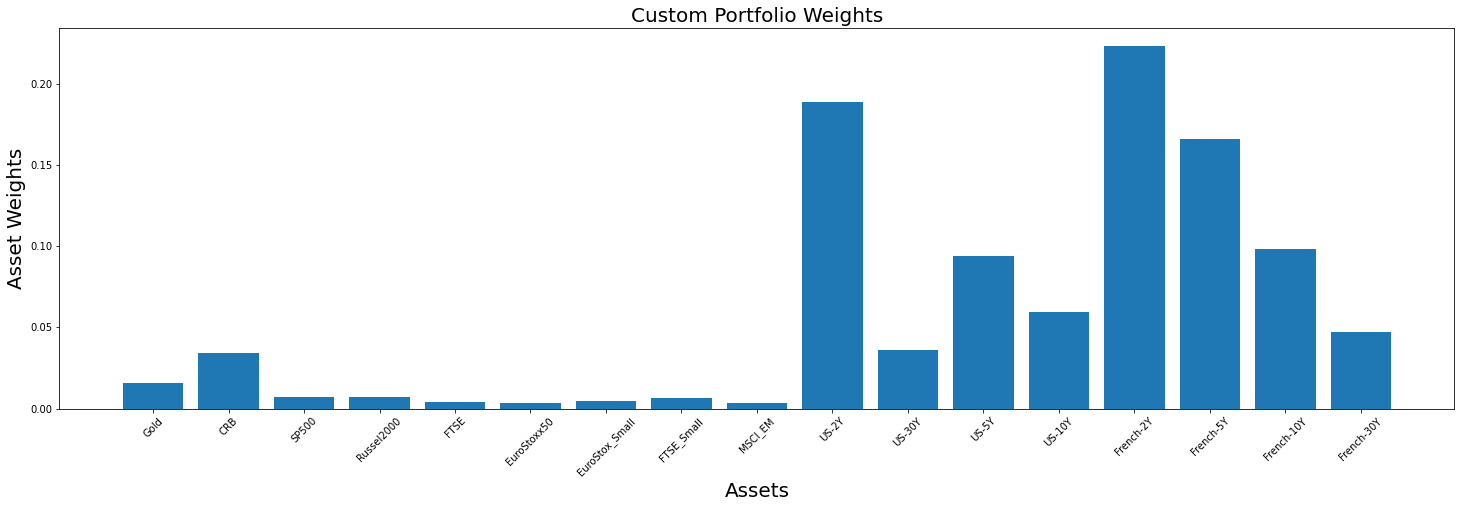

In [42]:
# plotting our optimal portfolio
customCDR_weights = hercCDR_custom.weights
y_pos = np.arange(len(customCDR_weights.columns))

plt.figure(figsize=(25,7))
plt.bar(list(customCDR_weights.columns), customCDR_weights.values[0])
plt.xticks(y_pos, rotation=45, size=10)
plt.xlabel('Assets', size=20)
plt.ylabel('Asset Weights', size=20)
plt.title('Custom Portfolio Weights', size=20)
plt.show()

Through this implementation, we can see alternative ways of which users can construct an optimal portfolio using the HCAA techniques implemented by MlFinLab.

## Conclusion
Throughout this notebook, we saw how we can apply Raffinot's work from his Hierarchical Equal Risk Contribution technique through the MlFinLab library. We worked through how we can specify many different parameters to solve for our optimal portfolio, including chaning our risk metrics and the type of linkage algorithms being used for clustering. Users were also made aware of how they can customize their input to have more control over their calculations. If you would like to learn more about the HERC technique, please refer to Raffinot's original paper linked at the top of this notebook. Additionally, please refer to the official documentation for this tutorial which can be found __[at this link](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_equal_risk_contribution.html)__ if you have any further questions.

## Sources
Official MlFinLab Documentation:
- __[Hierarchical Equal Risk Contribution](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_equal_risk_contribution.html)__
- __[Estimation of Returns](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/returns_estimation.html)__

Algorithms:
- __[Hierarchical Risk Parity - Hudson & Thames](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__
- __[Hierarchical Equal Risk Contribution - Thomas Raffinot](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237540)__
- __[Hierarchical Clustering Based Asset Allocation - Thomas Raffinot](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2840729)__